<a href="https://colab.research.google.com/github/Elshan777/CelebA-Detection/blob/master/DND_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - Object Detection | Semantic Segmentation

This notebook contains the required task for the second assignment of the Deep Network Development course. Read the task description and implement the empty code cells. Each section represents a stage along implementing your task [Object Detection or Semantic Segmantation], from loading and inspecting the dataset to testing a **pre-trained** model. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise inference can be very slow.

## Rules and Comments
- From the list of datasets and tasks listed in canvas, each student was atributed **1 task and 1 dataset** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- The emphasis of this assignment is put in the way you use and compare the different models. The metrics you present are very important.
- As always, copying others' code will make you fail the homework automatically (and thus the course). 
- **Deadline is April 24**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name: Elshan Gadimov**  
**Neptun ID: OV7MIK** 

## Task description
Given your task (Semantic Segmentation or Object Detection), you have to test three (3) pretrained models on the test set of a given dataset, comparing the results between the models. For the comparison, you have to use at least three (3) metrics commonly used in your task.

For example, if student A is given Object Detection task and the Ballons v2 dataset, then his/her task is to choose 3 pretrained object detection models [R-CNN, YOLO, ...] and evaluate them on the Ballons v2 test set, comparing the results using 3 metrics [mAP, Recall, ...]. If a dataset does not have a testing set, then the student should split at least 10% of the training set to create the test set.

For running test/evaluation/inference on a pre-trained model, it is important to know what are the model requirements, so that the input is preprocessed accordingly.
Make sure to explore the data and **present detailed evaluation metrics**.

**Please answer the questions.**



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [6]:
# ADD YOUR CODE HERE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torch
import os
from matplotlib.patches import Rectangle

from PIL import Image, ImageDraw,ImageOps
from torch.utils import data
from torchvision import transforms

## 1. Dataset 
Load the dataset you were given. If your data does not have a test set, split a portion of your training set (at least 10%).
Explore the dataset by visualizing the images and annotations.


#### Loading the dataset
Show some images and annotations of your dataset

In [2]:
!rm -rf celeba

In [3]:
# ADD YOUR CODE HERE
# It was mentioned that the there was an annotation problem with datasets from Kaggle, but fortunately I found the correct
# data from Kaggle 
os.environ['KAGGLE_USERNAME'] = "elshangadimov"
os.environ['KAGGLE_KEY'] = "dc78ef611b838449f7a58960e2a15014"

! kaggle datasets download -d kevinpatel04/celeba-original-wild-images
! unzip celeba-original-wild-images

Streaming output truncated to the last 5000 lines.
  inflating: Part 9/Part 9/085006.jpg  
  inflating: Part 9/Part 9/085007.jpg  
  inflating: Part 9/Part 9/085008.jpg  
  inflating: Part 9/Part 9/085009.jpg  
  inflating: Part 9/Part 9/085010.jpg  
  inflating: Part 9/Part 9/085011.jpg  
  inflating: Part 9/Part 9/085012.jpg  
  inflating: Part 9/Part 9/085013.jpg  
  inflating: Part 9/Part 9/085014.jpg  
  inflating: Part 9/Part 9/085015.jpg  
  inflating: Part 9/Part 9/085016.jpg  
  inflating: Part 9/Part 9/085017.jpg  
  inflating: Part 9/Part 9/085018.jpg  
  inflating: Part 9/Part 9/085019.jpg  
  inflating: Part 9/Part 9/085020.jpg  
  inflating: Part 9/Part 9/085021.jpg  
  inflating: Part 9/Part 9/085022.jpg  
  inflating: Part 9/Part 9/085023.jpg  
  inflating: Part 9/Part 9/085024.jpg  
  inflating: Part 9/Part 9/085025.jpg  
  inflating: Part 9/Part 9/085026.jpg  
  inflating: Part 9/Part 9/085027.jpg  
  inflating: Part 9/Part 9/085028.jpg  
  inflating: Part 9/Part 9/08

In [4]:
!rm -rf celeba-original-wild-images.zip
!rm -rf 'Part 21'

In [5]:
total_file_count = 0
for i in os.listdir():
  if i[0] == 'P':
    path = i + '/'+i
    print(path)
    print(len(os.listdir( path )))
    total_file_count += len(os.listdir( path ))
print('Total picture count', total_file_count)

Part 1/Part 1
10000
Part 18/Part 18
10000
Part 6/Part 6
10000
Part 7/Part 7
10000
Part 5/Part 5
10000
Part 20/Part 20
10000
Part 19/Part 19
10000
Part 13/Part 13
10000
Part 15/Part 15
10000
Part 11/Part 11
10000
Part 4/Part 4
10000
Part 14/Part 14
10000
Part 2/Part 2
10000
Part 16/Part 16
10000
Part 17/Part 17
10000
Part 8/Part 8
10000
Part 12/Part 12
10000
Part 3/Part 3
10000
Part 9/Part 9
10000
Part 10/Part 10
10000
Total picture count 200000


There are 21 parts in data and each one has 10000 pictures in it. We will use only one part because prediction in some of our models take a really long time

#### Pre-processing the dataset

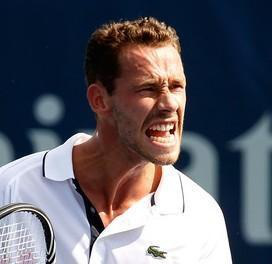

In [6]:
Image.open("/content/Part 7/Part 7/060011.jpg")

In [9]:
# ADD YOUR CODE HERE
from numpy.ma.core import resize
root = os.path.join('.', "Part 1", "Part 1")

num_samples = 2000
list_bbox = pd.read_csv(f"./list_bbox_celeba.csv")[:num_samples] # I wrote 60000 because of the index folder Part 7
img_orig_size = (178, 218) # taken from the web page of CelebA
img_channel = 3

images = np.zeros((num_samples, img_orig_size[1], img_orig_size[0], img_channel))
y = np.zeros((num_samples, 4))
resize_transformer = transforms.Compose([
      transforms.Resize((218, 178))
])

sizes = []
for i in range(len(list_bbox)):
    row = list_bbox.iloc[i]
    img = Image.open(f"{root}/" + row['image_id'])
    width, height = img.size
    sizes.append([width,height])
    # img = resize_transformer(img)
    img = img.resize((img_orig_size[0], img_orig_size[1]))
    img_arr = np.array(img)
    images[i] = img_arr
    # images[i] = img
    for j in range(1,5):
      if j%2 == 1:
        y[i][j-1] = int(row[j])/width*img_orig_size[0]
      else:
        y[i][j-1] = int(row[j])/height*img_orig_size[1]
print('Pre Proccess finished')

Pre Proccess finished


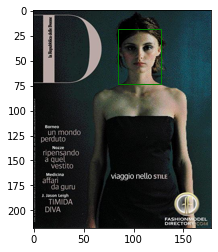

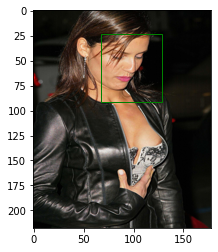

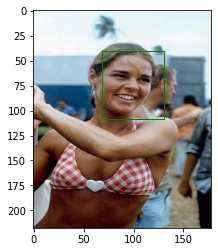

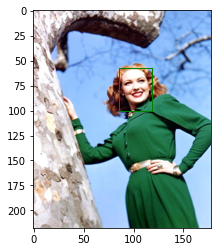

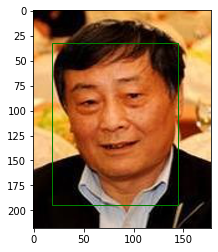

In [10]:
import matplotlib.patches as patches
import random

def show_random_images(n):

  for i in range(n):
    j = random.randint(0, num_samples)
    rect = patches.Rectangle((y[j][0], y[j][1]), y[j][2], y[j][3], linewidth=1, edgecolor='g', facecolor='none')

    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(images[j]/255)

    # Add rectangle
    ax.add_patch(rect)

    plt.show()

show_random_images(5)

## 2. Models
Load the 3 chosen models for your given task. Show the model's architecture.

For the first and second pretrained models I used Facenet-Pytorch's **CASIA-Webface** and **VGGFace2**. Although they have the same architecture (Inception ResNet v1) they have different backbones 
https://github.com/timesler/facenet-pytorch
The LFW accuracy of VGGFace2 is higher than CASIA-Webface but we will test them in our dataset with our custom evaluation methods


In [19]:
!pip install facenet-pytorch

### Question 1
Describe the main differences between the models you chose.

ADD ANSWER HERE

#### Load the models
Show the architectures

### First, We will test 4 models on single picture and later we will give the test data for detection, afterwards evaluating it

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [12]:
# ADD YOUR CODE HERE
from facenet_pytorch import MTCNN, InceptionResnetV1

mtcnn = MTCNN()

##### Casia WebFace

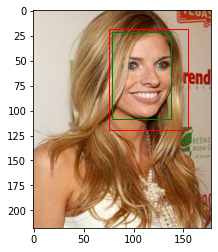

In [81]:
from PIL import Image
j = random.randint(0, num_samples) # Randomly select an image 


resnet = InceptionResnetV1(pretrained='casia-webface').eval().to(device)

boxes, probs = mtcnn.detect(images[j])
boxes

rect = patches.Rectangle((y[j][0], y[j][1]), y[j][2], y[j][3], linewidth=1, edgecolor='r', facecolor='none')
predicted = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2] - boxes[0][0], boxes[0][3]-boxes[0][1], linewidth=1, edgecolor='g', facecolor='none')

fig, ax = plt.subplots()

# Display the image
ax.imshow(images[j]/255)

# Add rectangle
ax.add_patch(rect)
ax.add_patch(predicted)

plt.show()

##### VGGFace2

[[ 78.61025   21.472477 137.84003  108.10974 ]]


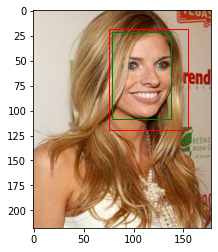

In [82]:
from PIL import Image
# j = random.randint(0, num_samples)
# j=10

resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

boxes, probs = mtcnn.detect(images[j])

rect = patches.Rectangle((y[j][0], y[j][1]), y[j][2], y[j][3], linewidth=1, edgecolor='r', facecolor='none')
predicted = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2] - boxes[0][0], boxes[0][3]-boxes[0][1], linewidth=1, edgecolor='g', facecolor='none')

fig, ax = plt.subplots()

# Display the image
ax.imshow(images[j]/255)

# Add rectangle
ax.add_patch(rect)
ax.add_patch(predicted)

plt.show()


##### RetinaFace

In [83]:
!pip install git+https://github.com/elliottzheng/face-detection.git@master

  Cloning https://github.com/elliottzheng/face-detection.git (to revision master) to /tmp/pip-req-build-xl3new02
  Running command git clone -q https://github.com/elliottzheng/face-detection.git /tmp/pip-req-build-xl3new02
  Created wheel for face-detection: filename=face_detection-1.0.5-py3-none-any.whl size=1638328 sha256=a1db2ece4d007deaab008fe468936458cd53958508dcdb649f37c87c46b9896e
  Stored in directory: /tmp/pip-ephem-wheel-cache-u39y2gnm/wheels/27/8f/8b/16350eed4526e15a515eda2f6ec106ad3a8646ade42452a993
Successfully built face-detection
  Attempting uninstall: face-detection
    Found existing installation: face-detection 0.2.1
    Uninstalling face-detection-0.2.1:
      Successfully uninstalled face-detection-0.2.1


In [84]:
from PIL import Image
from face_detection import RetinaFace

# j = random.randint(0, num_samples) # Randomly select an image 

model = RetinaFace()

faces = model(images[j])

boxes, landmarks, score = faces[0]

rect = patches.Rectangle((y[j][0], y[j][1]), y[j][2], y[j][3], linewidth=1, edgecolor='r', facecolor='none')
predicted = patches.Rectangle((boxes[0], boxes[1]), boxes[2]-boxes[0], boxes[3]-boxes[1], linewidth=1, edgecolor='g', facecolor='none')

fig, ax = plt.subplots()

# Display the image
ax.imshow(images[j]/255)

# Add rectangle
ax.add_patch(rect)
ax.add_patch(predicted)

plt.show()

ImportError: ignored


##### DSFD 
DSFD is our 4th model
https://github.com/hukkelas/DSFD-Pytorch-Inference

In [ ]:
!pip install git+https://github.com/hukkelas/DSFD-Pytorch-Inference.git

['DSFDDetector', 'RetinaNetResNet50', 'RetinaNetMobileNetV1']


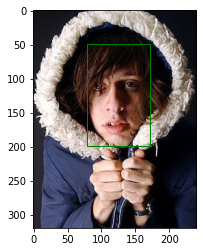

In [67]:
import cv2
import face_detection
import matplotlib.image as mpimg

print(face_detection.available_detectors)
detector = face_detection.build_detector(
  "DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)
# BGR to RGB
im = cv2.imread("/content/Part 5/Part 5/040001.jpg")[:, :, ::-1]
img = mpimg.imread("/content/Part 5/Part 5/040001.jpg")


detections = detector.detect(im)


# rect = patches.Rectangle((y[j][0], y[j][1]), y[j][2], y[j][3], linewidth=1, edgecolor='r', facecolor='none')
predicted = patches.Rectangle((detections[0][0], detections[0][1]), detections[0][2]-detections[0][0], detections[0][3]-detections[0][1], linewidth=1, edgecolor='g', facecolor='none')

fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Add rectangle
# ax.add_patch(rect)
ax.add_patch(predicted)

plt.show()

#### Now Lets detect the test imag. Later we will use the results for evaluation

In [85]:
resnet = InceptionResnetV1(pretrained='casia-webface').eval().to(device)

mtcnn = MTCNN(device=device)

resnet = InceptionResnetV1(pretrained='casia-webface').eval().to(device)

casia_webface_boxes = []
for i in range(2000):

  im = PIL_image = Image.fromarray(images[i].astype('uint8'), 'RGB')
  boxes, probs = mtcnn.detect(im)
  try:
    boxes = boxes[0]
    casia_webface_boxes.append(boxes)
  except:
    casia_webface_boxes.append([0,0,0,0])
  if i % 250 == 0:
    print(i)

0
250
500
750
1000
1250
1500
1750


In [80]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
mtcnn = MTCNN(device=device)

vggface2_boxes = []
for i in range(2000):
  im = PIL_image = Image.fromarray(images[i].astype('uint8'), 'RGB')
  boxes, probs = mtcnn.detect(im)
  try:
    boxes = boxes[0]
    vggface2_boxes.append(boxes)
  except:
    vggface2_boxes.append([0,0,0,0])
  if i % 250 == 0:
    print(i)

0
250
500
750
1000
1250
1500
1750


In [81]:
from skimage import io

model = RetinaFace()
retian_boxes = []

i = 0
for image in images:
  faces = model(image)
  try:
    box, landmarks, score = faces[0]
    retian_boxes.append(box)
  except:
    retian_boxes.append([0,0,0,0])
  if i % 250 == 0:
    print(i)
  i += 1

NameError: ignored

In [57]:
import cv2
import face_detection
from tqdm import tqdm



print(face_detection.available_detectors)
detector = face_detection.build_detector(
  "DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)

boxes_dsfdd = []
for i in tqdm(range(100)):
  # print(i)
  row = list_bbox.iloc[i]

  img = cv2.imread(f"/content/Part 1/Part 1/" + row['image_id'])[:, :, ::-1]
  faces = detector.detect(img)
  try:
    a = faces[0][0]/sizes[i][0]*img_orig_size[0]
    b = faces[0][1]/sizes[i][1]*img_orig_size[1]
    c = faces[0][2]/sizes[i][0]*img_orig_size[0]
    d = faces[0][3]/sizes[i][1]*img_orig_size[1]
    boxes_dsfdd.append([a,b,c,d])
  except:
    boxes_dsfdd.append([0,0,0,0])

['DSFDDetector', 'RetinaNetResNet50', 'RetinaNetMobileNetV1']


  1%|          | 1/100 [00:00<01:00,  1.64it/s]

0


 51%|█████     | 51/100 [00:41<00:28,  1.70it/s]

50


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


## 3. Evaluation
This is the most important part. Please give a detailed comparison between the models.

**Implement your metrics manually**. Do not use pre defined Pytorch metrics.

Calculate the metrics for each model on the test set.

Plot the metrics.

Show some predictions in comparison to the ground truth.

#### Evaluate your models

##### Intersection Over Union

In [43]:
def IOU(boxA, boxB):

  x1, y1, w1, h1 = boxA
  x2, y2, w2, h2 = boxB

  width_int = min(x1 + w1, x2 + w2) - max(x1, x2)
  height_int = min(y1 + h1, y2 + h2) - max(y1, y2)

  if width_int <= 0 or height_int <= 0: 
    return 0

  I = width_int * height_int
  U = w1 * h1 + w2 * h2 - I 

  return I / U

In [107]:
def precision(y, y_pred):
    precs = []
    for i in range(len(y_pred)):
        x1, y1, w1, h1 = y[i]
        x2, y2, w2, h2 = y_pred[i]

        width_int = min(x1 + w1, x2 + w2) - max(x1, x2)
        height_int = min(y1 + h1, y2 + h2) - max(y1, y2)

        if width_int <= 0 or height_int <= 0: 
          precs.append( true_percentage )
          continue

        I = width_int * height_int # Intersection
        A = w1*h1 # Area of the real box
        true_percentage = I/A if I/A<1 else 1
        precs.append( true_percentage )
    return np.mean(precs)

In [110]:
precision(y,vggface2_boxes)

0.8339906818354716

In [111]:
def recall(y, y_pred):
    true_region = []
    for i in range(len(y_pred)):
        x1, y1, w1, h1 = y[i]
        x2, y2, w2, h2 = y_pred[i]

        width_int = min(x1 + w1, x2 + w2) - max(x1, x2)
        height_int = min(y1 + h1, y2 + h2) - max(y1, y2)

        if width_int <= 0 or height_int <= 0: 
          true_region.append( true_percentage )
          continue

        I = width_int * height_int # Intersection
        A = w2*h2 # Area of the predicted box
        true_percentage = I/A if I/A<1 else 1
        true_region.append( true_percentage )
    return np.mean(true_region)

In [112]:
recall(y,vggface2_boxes)

0.4717376999653487

In [91]:
def rigth_wrong_threshold(y_true,y_pred,threshold):
  rigth_wrong = [0,0]
  for i in range(len(y_true)):
    if y_pred[i][0] + threshold > y_true[i][0] and y_pred[i][0] - threshold < y_true[i][0] and \
    y_pred[i][1] + threshold > y_true[i][1] and y_pred[i][1] - threshold < y_true[i][1] and \
    y_pred[i][2] + threshold > y_true[i][2] and y_pred[i][2] - threshold < y_true[i][2] and \
    y_pred[i][3] + threshold > y_true[i][3] and y_pred[i][3] - threshold < y_true[i][3]:
      rigth_wrong[0] += 1
    else:
      rigth_wrong[1] += 1
  return rigth_wrong

In [89]:
rigth_wrong_vggface = rigth_wrong_threshold(y,vggface2_boxes,50)
print(rigth_wrong_vggface[0]/(rigth_wrong_vggface[0] + rigth_wrong_vggface[1]))

0.6005


In [ ]:
rigth_wrong_vggface = rigth_wrong_threshold(y,vggface2_boxes,25)
print(rigth_wrong_vggface[0]/(rigth_wrong_vggface[0] + rigth_wrong_vggface[1]))

[68.86557377 28.76755448 35.01639344 43.81113801]


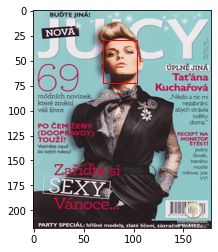

In [106]:
rect = patches.Rectangle((y[j][0], y[j][1]), y[j][2], y[j][3], linewidth=1, edgecolor='r', facecolor='none')

fig, ax = plt.subplots()
plt.imshow(images[j]/255)

ax.add_patch(rect)
print(y[j])
plt.show()

#### Show the metrics results

In [79]:
# ADD YOUR CODE HERE
for i in range(len(casia_webface_boxes)):
  casia_webface_boxes[i][2] = casia_webface_boxes[i][2] - casia_webface_boxes[i][0]
  casia_webface_boxes[i][3] = casia_webface_boxes[i][3] - casia_webface_boxes[i][1]
print('The result of CASIA-Webface with IOU', np.mean( [IOU(y[i], casia_webface_boxes[i]) for i in range(len(casia_webface_boxes))] ) )

NameError: ignored

In [102]:
# ADD YOUR CODE HERE
for i in range(len(vggface2_boxes)):
  vggface2_boxes[i][2] = vggface2_boxes[i][2] - vggface2_boxes[i][0]
  vggface2_boxes[i][3] = vggface2_boxes[i][3] - vggface2_boxes[i][1]
print('The result of VGG Face2 with IOU', np.mean( [IOU(y[i], vggface2_boxes[i]) for i in range(len(vggface2_boxes))] ) )

The result of VGG Face2 with IOU 0.5892211313267488


In [98]:
# ADD YOUR CODE HERE
for i in range(len(retian_boxes)):
  retian_boxes[i][2] = retian_boxes[i][2] - retian_boxes[i][0]
  retian_boxes[i][3] = retian_boxes[i][3] - retian_boxes[i][1]
print('The result of VGG Face2 with IOU', np.mean( [IOU(y[i], retian_boxes[i]) for i in range(len(retian_boxes))] ) )

The result of VGG Face2 with IOU 0.6172278594373646


In [54]:
for i in range(len(boxes_dsfdd)):
  boxes_dsfdd[i][2] = boxes_dsfdd[i][2] - boxes_dsfdd[i][0]
  boxes_dsfdd[i][3] = boxes_dsfdd[i][3] - boxes_dsfdd[i][1]
print('The result of DSFDD with IOU', np.mean( [IOU(y[i], boxes_dsfdd[i]) for i in range(len(boxes_dsfdd))] ) )

The result of DSFDD with IOU 0.6033799304121246


#### Show some predictions

In [ ]:
# ADD YOUR CODE HERE

# I showed them above

## 4. Conclusion

### Answer the questions
#### Question 2. 
Which model performed the best? Why do you think it performed better than others?

#### Question 3. 
How could you improve the performance of the models?

ADD ANSWERS HERE